## Generating facies realizations with GeostatsPy

We generate here a set of facies realizations (sand/ shale) using the fantastic geostatistical library _geostatspy_ (https://github.com/GeostatsGuy/GeostatsPy) by Michael Pyrcz (University of Texas, Austin).

The example is modified from his notebook https://github.com/GeostatsGuy/PythonNumericalDemos/GeostatsPy_sisim.ipynb

In [1]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats



### Load Data

We are using a data set that is also provided by Michael Pyrcz on https://github.com/GeostatsGuy/GeoDataSets

Two options here:

1. Generate data from scratch (from original data file
2. Load processed and adjusted data (with three facices)

In [216]:
# selection option

data_type = 'processed' # 'processed' or 'original'

if data_type == 'original':
    df = pd.read_csv("sample_data_MV_biased.csv")             # read a .csv file in as a DataFrame
    df.describe()                                             # summary statistics 
    df = df.sample(50)                                        # extract 50 samples
    df = df.reset_index()                                     # reset the record index 
    # adjust
    vals = df[["X", "Y", "Facies"]].values
    idx = np.where(vals[:,2] == 0)[0]
    select = np.random.choice(idx, size=10, replace=False)
    # set new facies 
    for s in select:
        vals[s,2] = 2
    df['Facies'] = vals[:,2]
    # save generated data
    # add random number to avoid acciental overwriting:
    num = np.random.randint(100000)
    f = open("data_frame_three_facies_%d.pkl" % num, mode='wb')
    pickle.dump(df, f)
    f.close()

elif data_type == 'processed':
    df = pickle.load(open("data_frame_three_facies_2.pkl", 'rb'))

df.head()

    

,index,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
0,312,486,0.0,549.0,1.0,0.173918,102.319997,3673.832356
1,269,428,680.0,429.0,1.0,0.116107,22.702807,6013.816976
2,84,133,140.0,499.0,1.0,0.138823,12.365241,3125.840089
3,303,476,340.0,739.0,1.0,0.146070,234.357400,3828.898027
4,5,9,200.0,900.0,1.0,0.129949,23.348473,4781.590782


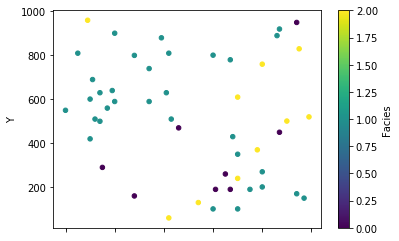

In [217]:
df.plot.scatter(x="X", y="Y", c="Facies", colormap='viridis')

### Generating Realizations

As a first step, we define the global model domain, the number of facies (with proportions) and the facies variograms:

In [218]:
# Sequential Indicator Simulation with Simple Kriging Multiple Realizations 
nx = 64; ny = 64; xsiz = 1000./nx; ysiz = 1000./ny; xmn = 10.0; ymn = 10.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; nodmax = 10; radius = 400; skmean = 0.5
tmin = -999; tmax = 999
dummy_trend = np.zeros((11,11))            # the current version requires trend input - if wrong size it is ignored 

ncut = 3                                   # number of facies

if ncut == 2: # standard version
    thresh = [0,1]                             # the facies categories (use consistent order)
    gcdf = [0.4,0.6]                           # the global proportions of the categories
    varios = []                                # the variogram list
    varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90,hmaj1=400,hmin1=100)) # shale indicator variogram
    # varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100)) # sand indicator variogram
    varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90,hmaj1=400,hmin1=100)) # sand indicator variogram

if ncut == 3: # adjusted for three facies (FW)
    thresh = [0,1,2]                             # the facies categories (use consistent order)
    # gcdf = [0.4,0.6]                           # the global proportions of the categories
    gcdf = [0.1,0.1,0.8]                           # the global proportions of the categories
    varios = []                                # the variogram list
    varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=0.8,cc2=0.2,azi1=90,hmaj1=400,hmin1=100)) # shale indicator variogram
    # varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100)) # sand indicator variogram
    varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=0.8,cc2=0.2,azi1=90,hmaj1=400,hmin1=100)) # sand indicator variogram
    varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=0.8,cc2=0.2,azi1=90,hmaj1=100,hmin1=100)) # facies 2 indicator variogram

    

Before we generate realizations, we set the random seed for later reproducibility (Technical side note: seeds need to be generated for subsequent implementation of GSLib functions):

In [219]:
n_realizations = 10
np.random.seed(seed = 12345)
seeds = np.random.choice(10000, n_realizations, replace=False)
seeds

array([7867, 1402, 8606, 8885, 6494, 9628, 7459, 3964, 7000, 4470])

We now can generate realizations (approx. 10s per realization for settings above!):

In [220]:
realizations = np.empty(shape=(n_realizations, nx, ny))

for i in range(n_realizations):
    
    # Added just for better checks during offline run:
    print("\n")
    print(80*"*")
    print("\n\n\t Realization %d \n\n"% i)
    print(80*"*")
    print("\n")
    
    realizations[i,:,:] = geostats.sisim(df,'X','Y','Facies',ivtype=0,koption=0,ncut=ncut,thresh=thresh,gcdf=gcdf,trend=dummy_trend,
                   tmin=tmin,tmax=tmax,zmin=0.0,zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,
                   nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=seeds[i],
                   ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,radius=radius,ktype=0,vario=varios)




********************************************************************************


	 Realization 0 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 7867
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 1 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 1402
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 2 


********************************************************************************


Data for IK3D: Variable column Facies
 

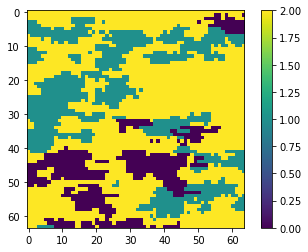

In [224]:
plt.imshow(realizations[0])
plt.colorbar()

### Plot realizations

Just to get an impression, here a plot of some realizations:

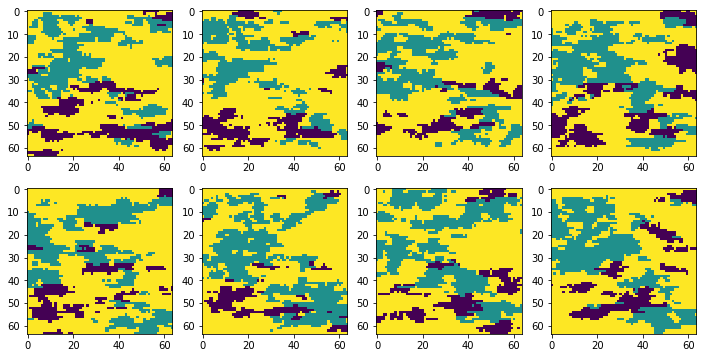

In [225]:
plt.figure(figsize=(12,6))
for i in range(1, 9):
    plt.subplot(2, 4, i)
    plt.imshow(realizations[i])

...and here simply the sum:

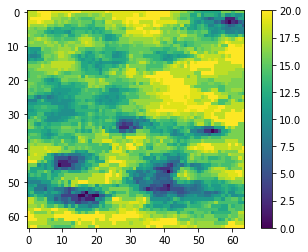

In [226]:
plt.imshow(np.sum(realizations, axis=0))
plt.colorbar()

...and the (estimated) probability for facies=1:

### Save realizations

Save realizations for further use later

In [227]:
import pickle

In [228]:
# add random int to filename to avoid overwriting
num = np.random.randint(100000)

f = open("facies_realizations_ncut_f3_aniso_64x64_%05d.pkl" % num, mode='wb')
pickle.dump(realizations, f)
f.close()

### Show conditioning points

It is also possible to show the conditioning points using proper GSLib functions - see github page of GeostatsPy (commented out here for now).

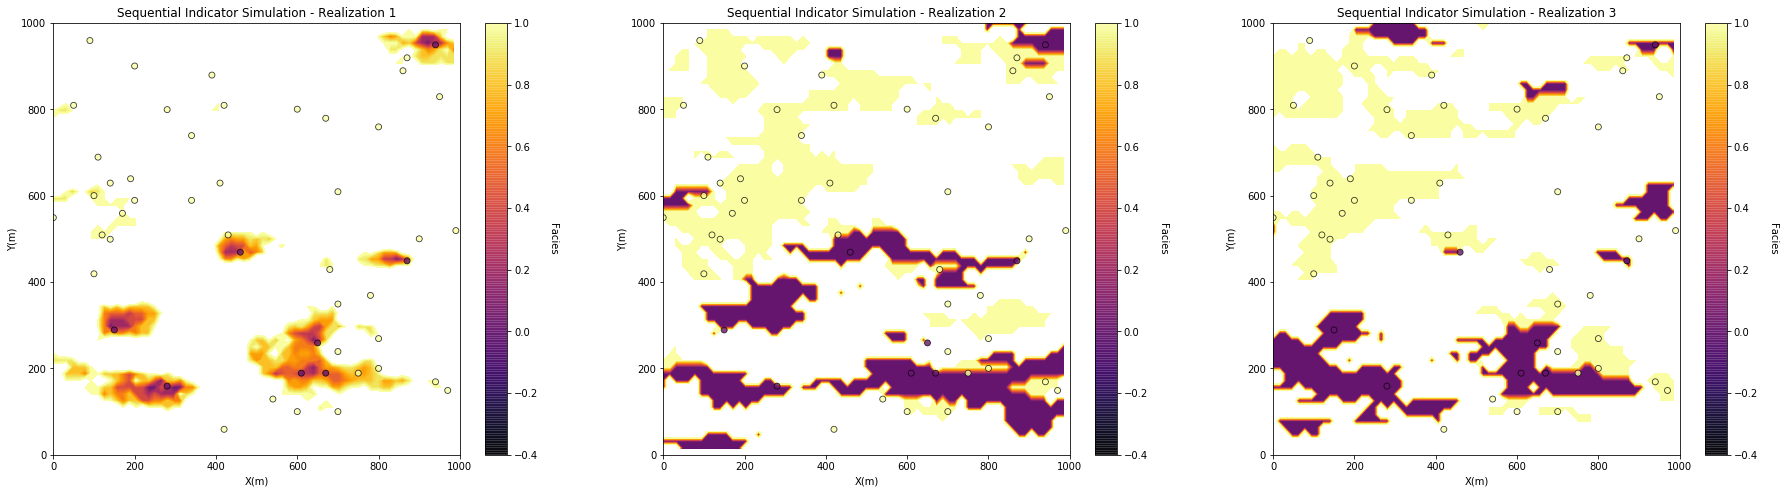

In [229]:
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno # plotting parameters

plt.subplot(131)                                          # plot the results
GSLIB.locpix_st(np.sum(realizations, axis=0)/n_realizations,xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Realization 1','X(m)','Y(m)','Facies',cmap)

plt.subplot(132)                                          # plot the results
GSLIB.locpix_st(realizations[1],xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Realization 2','X(m)','Y(m)','Facies',cmap)

plt.subplot(133)                                          # plot the results
GSLIB.locpix_st(realizations[2],xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Realization 3','X(m)','Y(m)','Facies',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()